In [567]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
used_cars_df = pd.read_csv('../data/used_cars.csv')

In [568]:
used_cars_df.head(2)

,Unnamed: 0,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
0,0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99


## Exploratory data analysis (EDA) and data cleaning

The target for our regression problem here is the column *price*. 

Each row represent the characteristics of a car, and the corresponding sales price of said car. We are free to choose which of the available features to fit a model to, and try to predict the target with.

It's generally essential that we use our wits and domain expertise to pick and engineer good features for our model. Bad features will produce a bad model, with poor predictive power. In other word, a useless model.

**Remove a redundant column**

In [569]:
# remove the first column which looks like a copy of the index column

columns_to_keep = used_cars_df.columns[1:]

columns_to_keep

Index(['car_name', 'registration_year', 'insurance_validity', 'fuel_type',
       'seats', 'kms_driven', 'ownsership', 'transmission',
       'manufacturing_year', 'mileage(kmpl)', 'engine(cc)', 'max_power(bhp)',
       'torque(Nm)', 'price(in lakhs)'],
      dtype='object')

In [570]:
clean_used_cars_df = used_cars_df[columns_to_keep]

clean_used_cars_df.head(2)

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99


**Keep only numerical columns, for now**

Many machine learning models require that the input are all numerical (since you can't do mathematic operations with anything else), and it is therefore essential that (when using models with that requirement) make sure that the data satisfies that condition.

Note that there are ways to transform any given column into numericals that we can work with, but let's hold on with that for now and only keep the features that already are.

In [571]:
clean_used_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   car_name            1553 non-null   object 
 1   registration_year   1553 non-null   object 
 2   insurance_validity  1553 non-null   object 
 3   fuel_type           1553 non-null   object 
 4   seats               1553 non-null   int64  
 5   kms_driven          1553 non-null   int64  
 6   ownsership          1553 non-null   object 
 7   transmission        1553 non-null   object 
 8   manufacturing_year  1553 non-null   object 
 9   mileage(kmpl)       1550 non-null   float64
 10  engine(cc)          1550 non-null   float64
 11  max_power(bhp)      1550 non-null   float64
 12  torque(Nm)          1549 non-null   float64
 13  price(in lakhs)     1553 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 170.0+ KB


In [572]:
clean_used_cars_df = clean_used_cars_df.select_dtypes(include=['int64', 'float64'])

clean_used_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seats            1553 non-null   int64  
 1   kms_driven       1553 non-null   int64  
 2   mileage(kmpl)    1550 non-null   float64
 3   engine(cc)       1550 non-null   float64
 4   max_power(bhp)   1550 non-null   float64
 5   torque(Nm)       1549 non-null   float64
 6   price(in lakhs)  1553 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 85.1 KB


**Deal with missing data**

Let's try to find and mitigate missing data. Note that whether to remove data points is a very sensitive decision, and should be carefully considered. 

Augmenting and fixing the data is a better alternative, if the time to do so is available. 

All changes we do to the training data *will* affect our model's performance, either insignificantly or significantly - depending on the changes we've made, and to what extent.

In [573]:
# check for null data

clean_used_cars_df.isnull().sum()

seats              0
kms_driven         0
mileage(kmpl)      3
engine(cc)         3
max_power(bhp)     3
torque(Nm)         4
price(in lakhs)    0
dtype: int64

We'll opt for the lazy way out here, and remove the null data since it's affecting a very low amount of records (not a good argument btw). 

This is generally not a recommended approach though, it might be well worth fixing the data instead.

**Question**: What consequences on the data does our decision to remove these records potentially have?

In [574]:
clean_used_cars_df = clean_used_cars_df.dropna().reset_index(drop=True)

clean_used_cars_df.isnull().sum()

seats              0
kms_driven         0
mileage(kmpl)      0
engine(cc)         0
max_power(bhp)     0
torque(Nm)         0
price(in lakhs)    0
dtype: int64

**Dealing with unreasonable data**

Usually, we have to spend considerable time to just clean the data and get rid of crap that has nested it's way into it.

Crap in data is very common in real life.

Let's begin by trying to understand the price column a bit better.

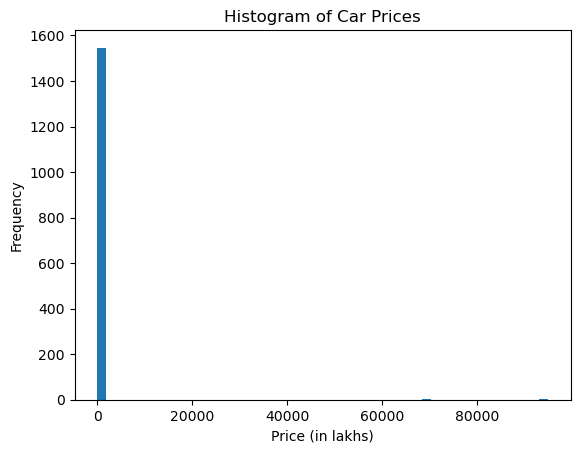

In [575]:
plt.hist(clean_used_cars_df['price(in lakhs)'], bins=50)
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')
plt.title('Histogram of Car Prices')
plt.show()

That's strange, it looks like there are a few cars that are extremely expensive. This is not incorrect per se, but let's look deeper.

In [576]:
clean_used_cars_df[clean_used_cars_df['price(in lakhs)']>=100.5]

,seats,kms_driven,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
173,5,66717,1196.0,70.0,70.0,102.0,70000.0
193,5,66717,1196.0,70.0,70.0,102.0,70000.0
1273,5,44002,19.7,796.0,796.0,463.0,95000.0


Ok, so we have 3 records of cars that looks to suspicous.

Since Ali has been in India, he knows that 1 lakh is a common indian measure that means one hundred thousand (indian rupees, in this case).

70000 lakhs is therefore 70000 * 100.000 = 7000000000 (indian rupees).

Converting this to Swedish currency we get 877 447 200 SEK. Not reasonably at all. 

Let's just remove these records for simplicity, and plot again

Text(0, 0.5, 'Frequency')

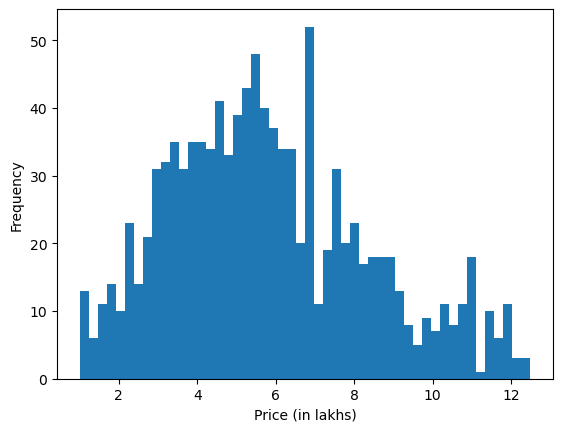

In [577]:
clean_used_cars_df = clean_used_cars_df[clean_used_cars_df['price(in lakhs)']<12.5].reset_index(drop=True)
plt.hist(clean_used_cars_df['price(in lakhs)'], bins=50)
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')

Ah, now it looks much more realistic!

Ok, great. Let's also take a look at kms_driven

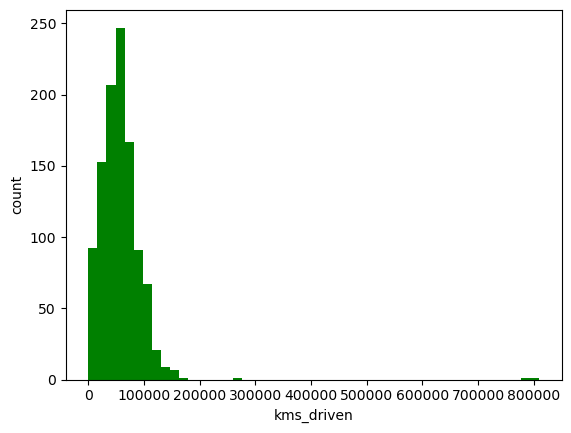

In [578]:
plt.hist(clean_used_cars_df['kms_driven'], bins=50, color='green');

plt.xlabel('kms_driven');
plt.ylabel('count');

Well, this also looks a little suspicious. Perhaps?

In [579]:
clean_used_cars_df[clean_used_cars_df['kms_driven']>150000]

,seats,kms_driven,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
675,5,790000,18.15,998.0,998.0,11835.0,9.75
709,5,810000,21.70,1498.0,1498.0,9896.0,9.00
941,7,176000,12.80,2494.0,2494.0,102.0,4.40
962,7,260000,12.80,2494.0,2494.0,102.0,6.25


Ok, so there are only 6 cars that have droven over 150.000 kms. Let's remove them, since they deviate in too much in values from our other values, and thus much deteroriate the models performance.

We can of course do this if we'd like, but let's think for a moment before doing so. What limitations are we putting on our model by removing these records?

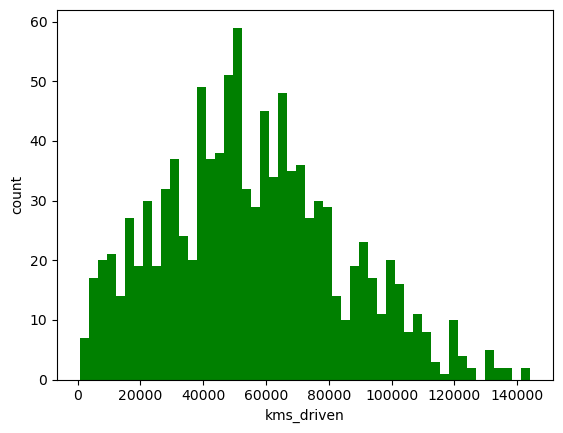

In [580]:
clean_used_cars_df = clean_used_cars_df[clean_used_cars_df['kms_driven']<150000].reset_index(drop=True)

plt.hist(clean_used_cars_df['kms_driven'], bins=50, color='green');

plt.xlabel('kms_driven');
plt.ylabel('count');

Alright, looks like we have a good range 

---

**Bonus task**


Try to do some analysis (perhaps plots and calculating simple metrics such as min, max, mean, std etc.) on each of these remaining columns. Is there something in particular you find interesting? 

Can we do something about it? If you find any notable outliers, remove them for now.

---

In [581]:
clean_used_cars_df

,seats,kms_driven,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
0,5,30615,17.40,999.0,999.0,9863.0,8.99
1,5,42000,18.70,1199.0,1199.0,887.0,5.45
2,5,36739,18.90,1197.0,1197.0,8186.0,5.12
3,5,76000,15.80,1591.0,1591.0,1213.0,9.30
4,5,28783,17.00,1198.0,1198.0,1085.0,8.02
...,...,...,...,...,...,...,...
1049,7,26500,26.11,1462.0,1462.0,8663.0,11.50
1050,5,10000,999.00,6706.0,6706.0,91.0,3.98
1051,5,49000,17.50,1199.0,1199.0,887.0,5.85
1052,5,40000,18.78,999.0,999.0,75.0,4.75


In [582]:
seats_desc = clean_used_cars_df["seats"].describe()
driven_desc = clean_used_cars_df["kms_driven"].describe()
mileage_desc = clean_used_cars_df["mileage(kmpl)"].describe()
engine_desc = clean_used_cars_df["engine(cc)"].describe()
power_desc = clean_used_cars_df["max_power(bhp)"].describe()
torque_desc = clean_used_cars_df["torque(Nm)"].describe()


print(f"seats: {seats_desc}")
print(f"kms_driven: {driven_desc}")
print(f"mileage(kmpl): {mileage_desc}")
print(f"engine: {engine_desc}")
print(f"max_power: {power_desc}")
print(f"torque: {torque_desc}")

seats: count    1054.000000
mean        5.105313
std         0.470709
min         4.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         8.000000
Name: seats, dtype: float64
kms_driven: count      1054.000000
mean      55597.745731
std       28599.276460
min         620.000000
25%       35000.000000
50%       52975.000000
75%       73456.500000
max      144234.000000
Name: kms_driven, dtype: float64
mileage(kmpl): count    1054.000000
mean      197.913956
std       490.060806
min         7.810000
25%        17.800000
50%        19.490000
75%        22.597500
max      3996.000000
Name: mileage(kmpl), dtype: float64
engine: count    1.054000e+03
mean     2.164183e+10
std      2.648038e+11
min      6.700000e+01
25%      1.197000e+03
50%      1.199000e+03
75%      1.498000e+03
max      3.258640e+12
Name: engine(cc), dtype: float64
max_power: count    1.054000e+03
mean     2.164183e+10
std      2.648038e+11
min      6.700000e+01
25%      1.197000e+03
50%      1.

## Linear Regression

We'll begin our model fitting by limiting ourselves to a single feature.

We'll try to predict car prices using km_driven as the sole feature, for now. 

Note that this is obviously very limiting, but we do it for pedagocical reasons in order to both get used to the sk-learn package, and to learn an important lesson...

In other words, we'll now assume that we can model

$$ price = w_1 \cdot (kms\ driven) + w_0

In [583]:
X, y = clean_used_cars_df['kms_driven'].values, clean_used_cars_df['price(in lakhs)'].values

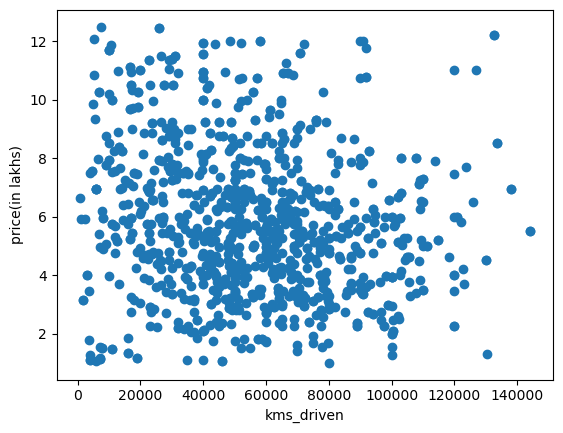

In [584]:
plt.scatter(X, y)
plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');

#plt.ylim()

Train/test split

In [585]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # set a random state, so we can reproduce our results

print('Train set:')
print('X:', len(X_train))
print('y:', len(y_train), end='\n\n')

print('Test set:')
print('X:', len(X_test))
print('y:', len(y_test))

Train set:
X: 843
y: 843

Test set:
X: 211
y: 211


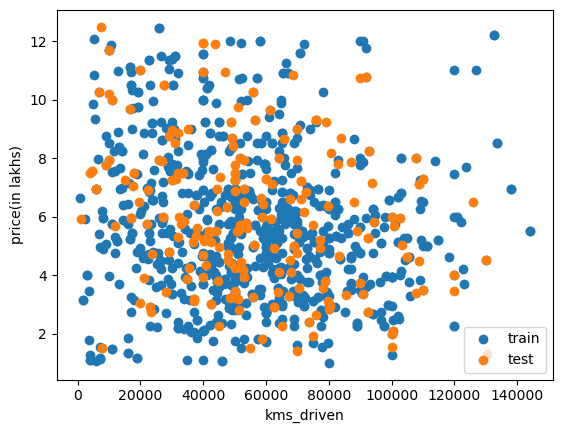

In [586]:
plt.scatter(X_train, y_train, label = 'train')
plt.scatter(X_test, y_test, label = 'test')

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');

plt.legend();

In [587]:
# import a linear regression model and the MSE-metric from sklearn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [588]:
# this initialized a linear regression model. It has not trained on anything yet

linear_regression_model = LinearRegression()

These models require a 2D-input, but our current data is 1D

In [589]:
print(X_train.shape)
print(y_train.shape)

(843,)
(843,)


We can mitigate this using the .reshape method

In [590]:
X_train = X_train.reshape(len(X_train), 1)
y_train = y_train.reshape(len(y_train), 1)

print(X_train.shape)
print(y_train.shape)

(843, 1)
(843, 1)


Note that we can pass in a -1 in the .reshape method aswell, it then automatically tries to infer the dimension given your data

In [591]:
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(X_test.shape)
print(y_test.shape)

(211, 1)
(211, 1)


Let's train!

In [592]:
linear_regression_model.fit(X_train, y_train);

In [593]:
linear_regression_model.intercept_

array([6.39238334])

In [594]:
linear_regression_model.coef_

array([[-1.15057776e-05]])

In [595]:
y_train_hat = linear_regression_model.predict(X_train)
y_test_hat = linear_regression_model.predict(X_test)

In [596]:
# beräkna loss på train set

print(mean_squared_error(y_train, y_train_hat))

print(np.sqrt(mean_squared_error(y_train, y_train_hat)))

6.412353843837338
2.532262593776036


In [597]:
# beräkna loss på test set

print(mean_squared_error(y_test, y_test_hat))

print(np.sqrt(mean_squared_error(y_test, y_test_hat)))

5.868049469514665
2.4224057194274176


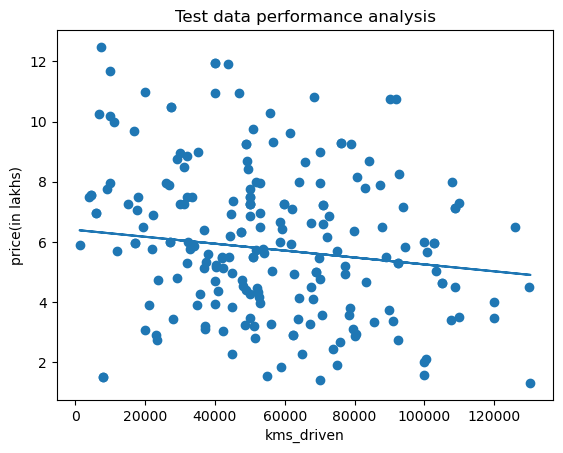

In [598]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_hat)

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');
plt.title('Test data performance analysis');

Is the above result any good? Can you draw any conclusions?

If we really insisted, for some reason, on fitting a straight line to our data - what would be the correct course of action?

**Polynomial regression**

If we for some reason believe that a single feature in itself is not good enough, and that we might need powers of that feature, we can try to fit a polynomial model instead.

In [599]:
X_train.shape

(843, 1)

In [600]:
from sklearn.preprocessing import PolynomialFeatures

# assume that we want to create features for polynomial of degree two

poly_transform = PolynomialFeatures(degree=2, include_bias=False) # this initializes our transformer

X_train_polynomial = poly_transform.fit_transform(X_train)

X_test_polynomial = poly_transform.transform(X_test)           # not that we do NOT fit on the test set, only transform it. More on this later.



What we now have created are powers of our feature km_driven.

In other words, we now have two columns where each are

$km\ driven, (km\  driven)^2$

In [601]:
X_train_polynomial

array([[1.65700000e+04, 2.74564900e+08],
       [5.70000000e+04, 3.24900000e+09],
       [6.50000000e+04, 4.22500000e+09],
       ...,
       [5.74530000e+04, 3.30084721e+09],
       [1.61000000e+04, 2.59210000e+08],
       [6.60190000e+04, 4.35850836e+09]], shape=(843, 2))

We can now use these as features for our linear regression model we imported earlier (which supports multiple features).

This would allow to model

$$ price = w_2 \cdot (km\ driven)^2 + w_1 \cdot (km\ driven) + w_0 $$

In [602]:
# initialize and fit the model

polynomial_regression_degree_2_model = LinearRegression()      # NOTERA ATT DEN HÄR KLARAR AV BÅDE EN ELLER FLERA FEATURES

polynomial_regression_degree_2_model.fit(X_train_polynomial, y_train)

LinearRegression()

In [603]:
polynomial_regression_degree_2_model.intercept_

array([6.9424278])

In [604]:
polynomial_regression_degree_2_model.coef_

array([[-3.49051593e-05,  1.92302363e-10]])

In [605]:
# predict and calculate loss

y_train_hat = polynomial_regression_degree_2_model.predict(X_train_polynomial)
y_test_hat = polynomial_regression_degree_2_model.predict(X_test_polynomial)

print('Train MSE:', mean_squared_error(y_train, y_train_hat))
print('Test MSE:', mean_squared_error(y_test, y_test_hat))

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_hat)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_hat)))

Train MSE: 6.3717792505332165
Test MSE: 5.87492582053403
Train RMSE: 2.5242383505788863
Test RMSE: 2.423824626604415


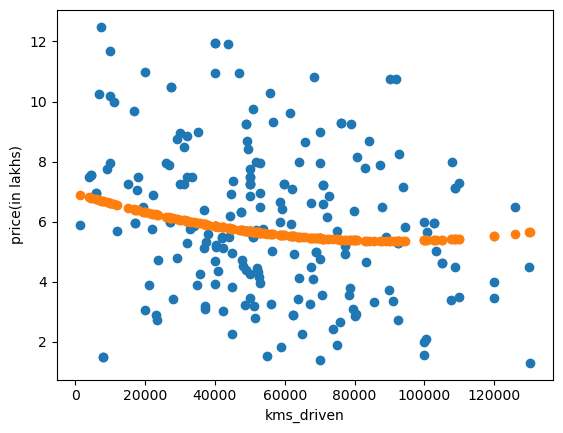

In [606]:
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_test_hat)

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');

Is that really better in any meaningul way? 

Hmm... Is there some sort of conclusion we can draw here?

What should we do?

---

## Challanges

**Task 1**

Clearly, trying to model car prices using km_driven alone atleast seems difficult with linear or polynomial models.

But if you were forced to do it anyway, what should we do? Look at the plots above and see if you can come up with an idea.

<details>
  <summary>Answer</summary>
  Predicting for both expensive and cheaper cars simultaneously with one model doesn't seem to be a good idea. We might get much better performance if we instead split those stratas and train a model on each seperately.
</details>



Split the data for example: expensive and cheap cars.

**Task 2**

Create two datasets from used_cars_df, called used_expensive_cars_df and used_cheap_cars_df. Define cheap to be a car that costs 12.5 lakh or less.

Train a linear model on the used_cheap_cars_df data and try to predict the sales price using only kms_driven.

What do you end up with? Is it better than before? 

*Hint:* You can use pretty much everything we've done above!

In [607]:
used_expensive_cars_df = clean_used_cars_df[clean_used_cars_df["price(in lakhs)"]>12.5].reset_index(drop=True)
used_cheap_cars_df = clean_used_cars_df[clean_used_cars_df["price(in lakhs)"]<=12.5].reset_index(drop=True)

X, y = used_cheap_cars_df['kms_driven'].values, used_cheap_cars_df['price(in lakhs)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30) 

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

linear_regression_model.fit(X_train, y_train);
linear_regression_model.intercept_
linear_regression_model.coef_

y_train_hat = linear_regression_model.predict(X_train)
y_test_hat = linear_regression_model.predict(X_test)

print('Train MSE:', mean_squared_error(y_train, y_train_hat))
print('Test MSE:', mean_squared_error(y_test, y_test_hat))

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_hat)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_hat)))

Train MSE: 6.316906219882848
Test MSE: 6.220280298155124
Train RMSE: 2.513345622846736
Test RMSE: 2.49404897669535


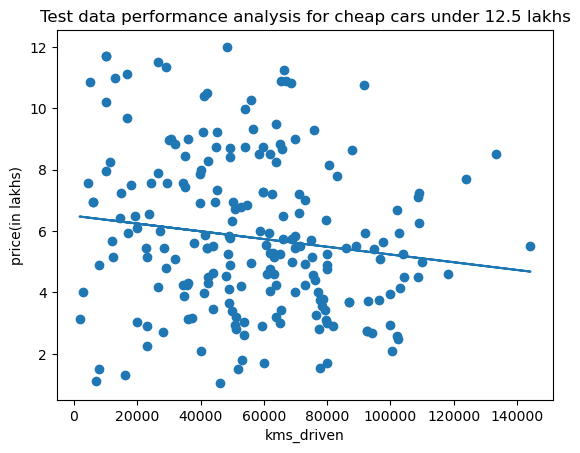

In [608]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_hat)

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');
plt.title('Test data performance analysis for cheap cars under 12.5 lakhs');
plt.show()


In [609]:
print(used_expensive_cars_df)
#the dataset for expensive cars is empty but I still got diffrent numbers

Empty DataFrame
Columns: [seats, kms_driven, mileage(kmpl), engine(cc), max_power(bhp), torque(Nm), price(in lakhs)]
Index: []


**Task 3**

Instead of kms_driven, now try using one of the other available features to model price. Do you get better performance? Limit your analysis to cheap cars.

Which of the feature seem to be the single best one at predicting car price?

*Hint:* You might need to deal with some unreasonable data in the other features aswell.



In [610]:
used_cheap_cars_df = used_cheap_cars_df.drop(columns=['max_power(bhp)'])
used_cheap_cars_df


,seats,kms_driven,mileage(kmpl),engine(cc),torque(Nm),price(in lakhs)
0,5,30615,17.40,999.0,9863.0,8.99
1,5,42000,18.70,1199.0,887.0,5.45
2,5,36739,18.90,1197.0,8186.0,5.12
3,5,76000,15.80,1591.0,1213.0,9.30
4,5,28783,17.00,1198.0,1085.0,8.02
...,...,...,...,...,...,...
1049,7,26500,26.11,1462.0,8663.0,11.50
1050,5,10000,999.00,6706.0,91.0,3.98
1051,5,49000,17.50,1199.0,887.0,5.85
1052,5,40000,18.78,999.0,75.0,4.75


Train MSE: 6.279054040965647
Test MSE: 5.890129619081816
Train RMSE: 2.5058040707456852
Test RMSE: 2.426958924061513


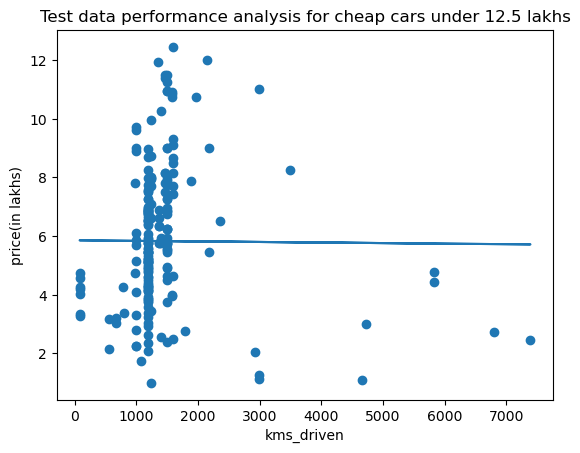

In [611]:
used_cheap_cars_df = used_cheap_cars_df[used_cheap_cars_df["engine(cc)"] < 8000]

X, y = used_cheap_cars_df['engine(cc)'].values, used_cheap_cars_df['price(in lakhs)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30) 

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

linear_regression_model.fit(X_train, y_train);
linear_regression_model.intercept_
linear_regression_model.coef_

y_train_hat = linear_regression_model.predict(X_train)
y_test_hat = linear_regression_model.predict(X_test)

print('Train MSE:', mean_squared_error(y_train, y_train_hat))
print('Test MSE:', mean_squared_error(y_test, y_test_hat))

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_hat)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_hat)))
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_hat)

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');
plt.title('Test data performance analysis for cheap cars under 12.5 lakhs');
plt.show()

Train MSE: 5.569804117090139
Test MSE: 5.476348717713903
Train RMSE: 2.3600432447500066
Test RMSE: 2.3401599769489914


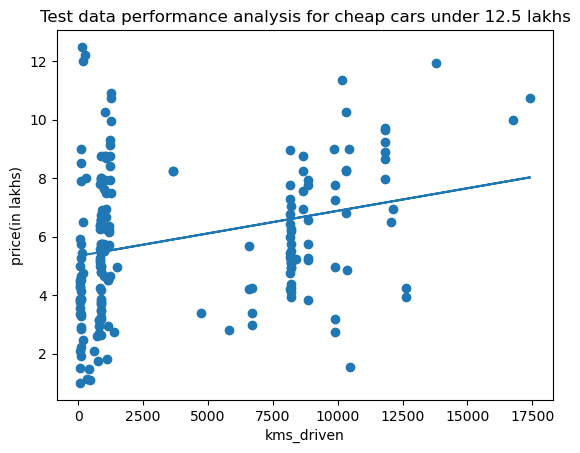

In [612]:
used_cheap_cars_df = used_cheap_cars_df[used_cheap_cars_df["torque(Nm)"] < 25000]
X, y = used_cheap_cars_df["torque(Nm)"].values, used_cheap_cars_df['price(in lakhs)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30) 

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

linear_regression_model.fit(X_train, y_train);
linear_regression_model.intercept_
linear_regression_model.coef_

y_train_hat = linear_regression_model.predict(X_train)
y_test_hat = linear_regression_model.predict(X_test)

print('Train MSE:', mean_squared_error(y_train, y_train_hat))
print('Test MSE:', mean_squared_error(y_test, y_test_hat))

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_hat)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_hat)))
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_hat)

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');
plt.title('Test data performance analysis for cheap cars under 12.5 lakhs');
plt.show()

Train MSE: 5.583056779788519
Test MSE: 5.97821835171536
Train RMSE: 2.362849292652521
Test RMSE: 2.4450395399083753


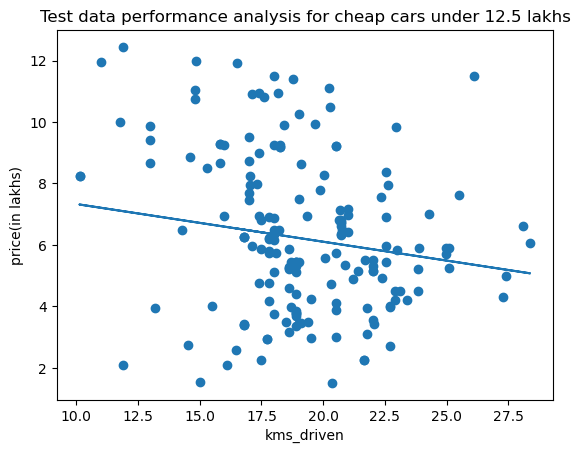

In [613]:
used_cheap_cars_df = used_cheap_cars_df[used_cheap_cars_df["mileage(kmpl)"] < 30].reset_index(drop=True)
X, y = used_cheap_cars_df["mileage(kmpl)"].values, used_cheap_cars_df['price(in lakhs)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30) 

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

linear_regression_model.fit(X_train, y_train);
linear_regression_model.intercept_
linear_regression_model.coef_

y_train_hat = linear_regression_model.predict(X_train)
y_test_hat = linear_regression_model.predict(X_test)

print('Train MSE:', mean_squared_error(y_train, y_train_hat))
print('Test MSE:', mean_squared_error(y_test, y_test_hat))

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_hat)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_hat)))
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_hat)

plt.xlabel('kms_driven');
plt.ylabel('price(in lakhs)');
plt.title('Test data performance analysis for cheap cars under 12.5 lakhs');
plt.show()

**Task 4**

We have not learned how to work with non-numeric columns yet as features for ML-models. However, see if you still can try to analyze the original columns we removed. Look for outliers, faulty data and other irregularities

In [619]:
columns_to_keep = used_cars_df.columns[1:]
used_cars_df = used_cars_df[columns_to_keep]
used_cars_df = used_cars_df[used_cars_df["fuel_type"] != "5 Seats"].reset_index(drop=True)
used_cars_df = used_cars_df[used_cars_df["manufacturing_year"] != "Power Steering"].reset_index(drop=True)
used_cars_df = used_cars_df[used_cars_df["manufacturing_year"] != "Power Windows Front"].reset_index(drop=True)
used_cars_df = used_cars_df.dropna().reset_index(drop=True)
